# Predicción de diabetes

## 1. Introducción

El conjunto de datos a trabajar es una colección de información médica y demográfica de pacientes, junto con su diagnóstico de diabetes (positivo o negativo). Las *features* que contiene el dataset son:

- Edad
- Género
- Índice de Masa Corporal (BMI)
- Hipertensión
- Condición cardíaca
- Historial de fumador
- Nivel de HbA1c
- Nivel de glucosa en sangre

Se disponen de 95.000 datos etiquetados para realizar las tareas de entrenamiento, validación y evaluación con el objetivo de desarrollar un modelo de aprendizaje supervisado capaz de predecir si un paciente tiene diabetes o no. Además, disponemos de un conjunto de evaluación sin etiquetas de 5.000 datos, sobre el cual deben realizarse las predicciones finales. De esos 5.000 datos, un 30% es utilizado para calcular la *accuracy* de las predicciones y confeccionar un leaderboard público en la plataforma Kaggle, mientras que el 70% restante se utiliza en el leaderboard final.

El objetivo del trabajo es desarrollar al menos tres modelos distintos de aprendizaje automático que sobrepasen la *baseline accuracy* del 97,266%, obtenida por un modelo de árboles de decisión con todas las variables por defecto de ```sklearn```. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train_df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


## 2. Exploración y Visualización

Vamos a ver cada variable en detalle, identificando el tipo de variable en cuestión. Es interesante notar que no hay valores nulos (NaNs) en ninguna de las entradas, con lo cual no será necesario imputar datos. Además, el número de paciente no será una variable de interés en la predicción, por lo que no vamos a considerarla una variable de estudio.

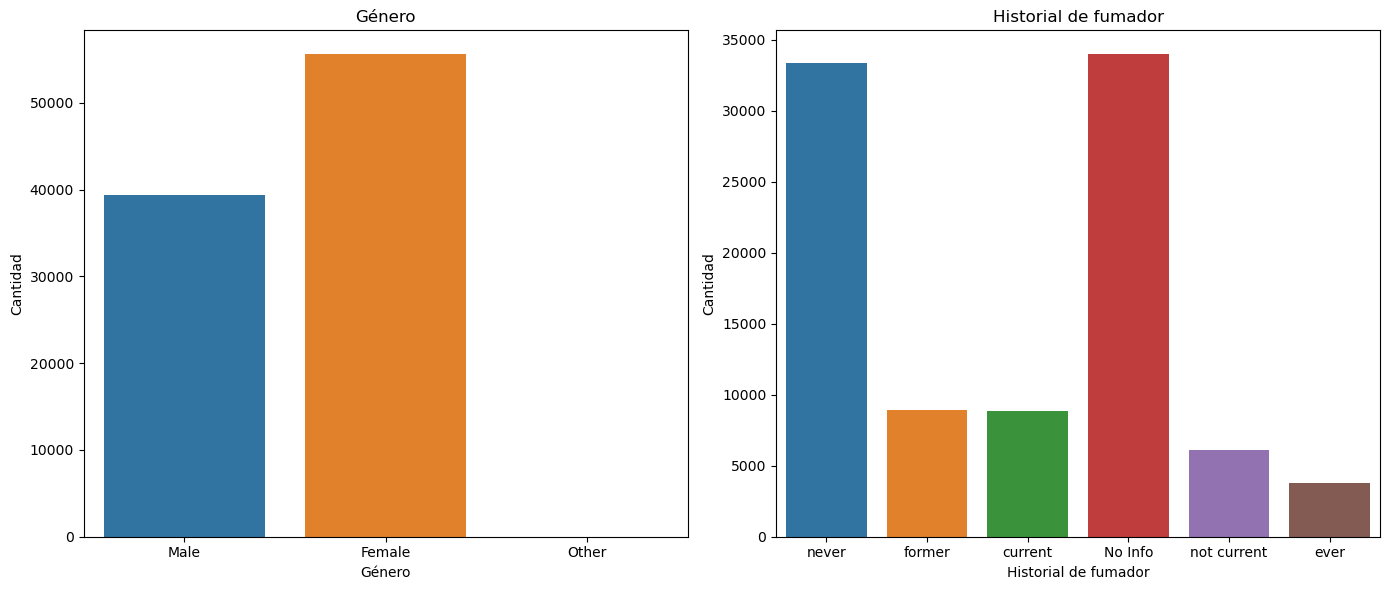

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(ax=axes[0], x='gender', data=train_df)
axes[0].set_title('Género')
axes[0].set_xlabel('Género')
axes[0].set_ylabel('Cantidad')
    
sns.countplot(ax=axes[1], x='smoking_history', data=train_df)
axes[1].set_title('Historial de fumador')
axes[1].set_xlabel('Historial de fumador')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

Estas dos variables constituyen *variables categóricas*, que deberán ser transformadas mediante un ```encoding``` apropiado. Podemos notar también que existen muchos pacientes sin información respecto a su historial de fumador. Un estudio más completo podría buscar la forma de imputar estos datos, o de sólo utilizar esa variable en los casos en los que sí se conoce. No obstante, en este trabajo fue considerada como una variable más.

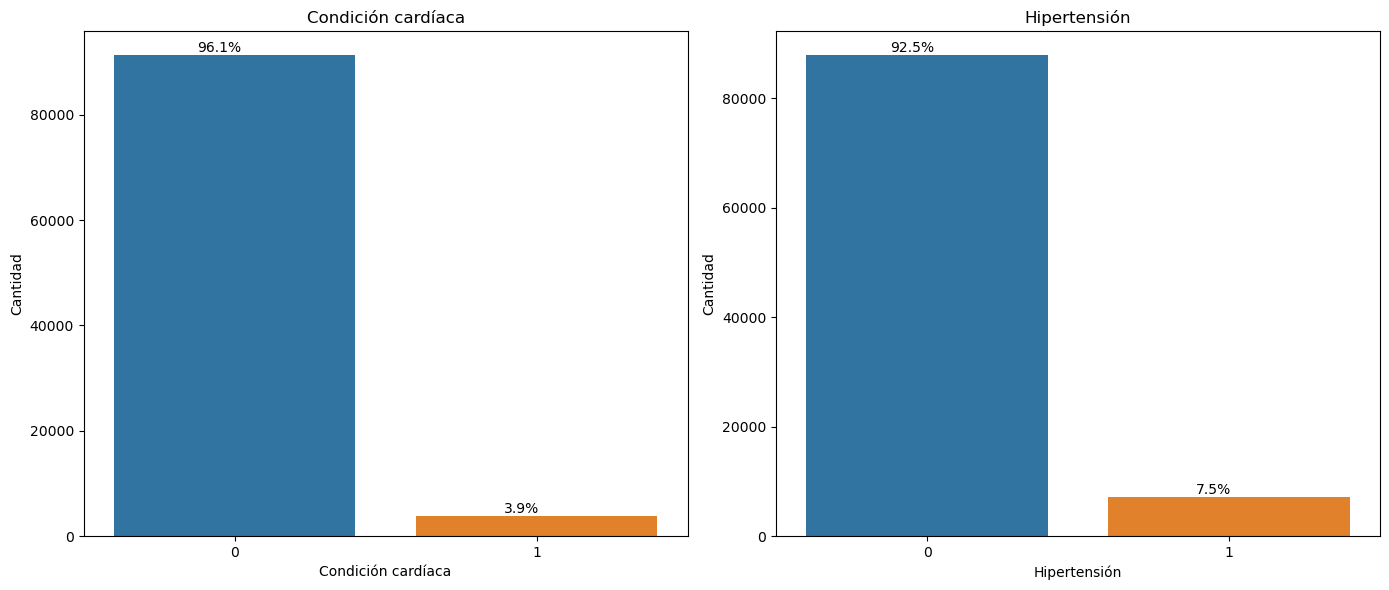

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(ax=axes[0], x='heart_disease', data=train_df)
axes[0].set_title('Condición cardíaca')
axes[0].set_xlabel('Condición cardíaca')
axes[0].set_ylabel('Cantidad')

total1 = len(train_df['heart_disease'])
for p in axes[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total1)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')
    
sns.countplot(ax=axes[1], x='hypertension', data=train_df)
axes[1].set_title('Hipertensión')
axes[1].set_xlabel('Hipertensión')
axes[1].set_ylabel('Cantidad')

total2 = len(train_df['hypertension'])
for p in axes[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total2)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    axes[1].annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Estas dos variables también son categóricas, pero binarias, por lo que no precisan de una transormación. Vemos que hay una gran mayoría (más del 90%) de pacientes que no presentan estas condiciones

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

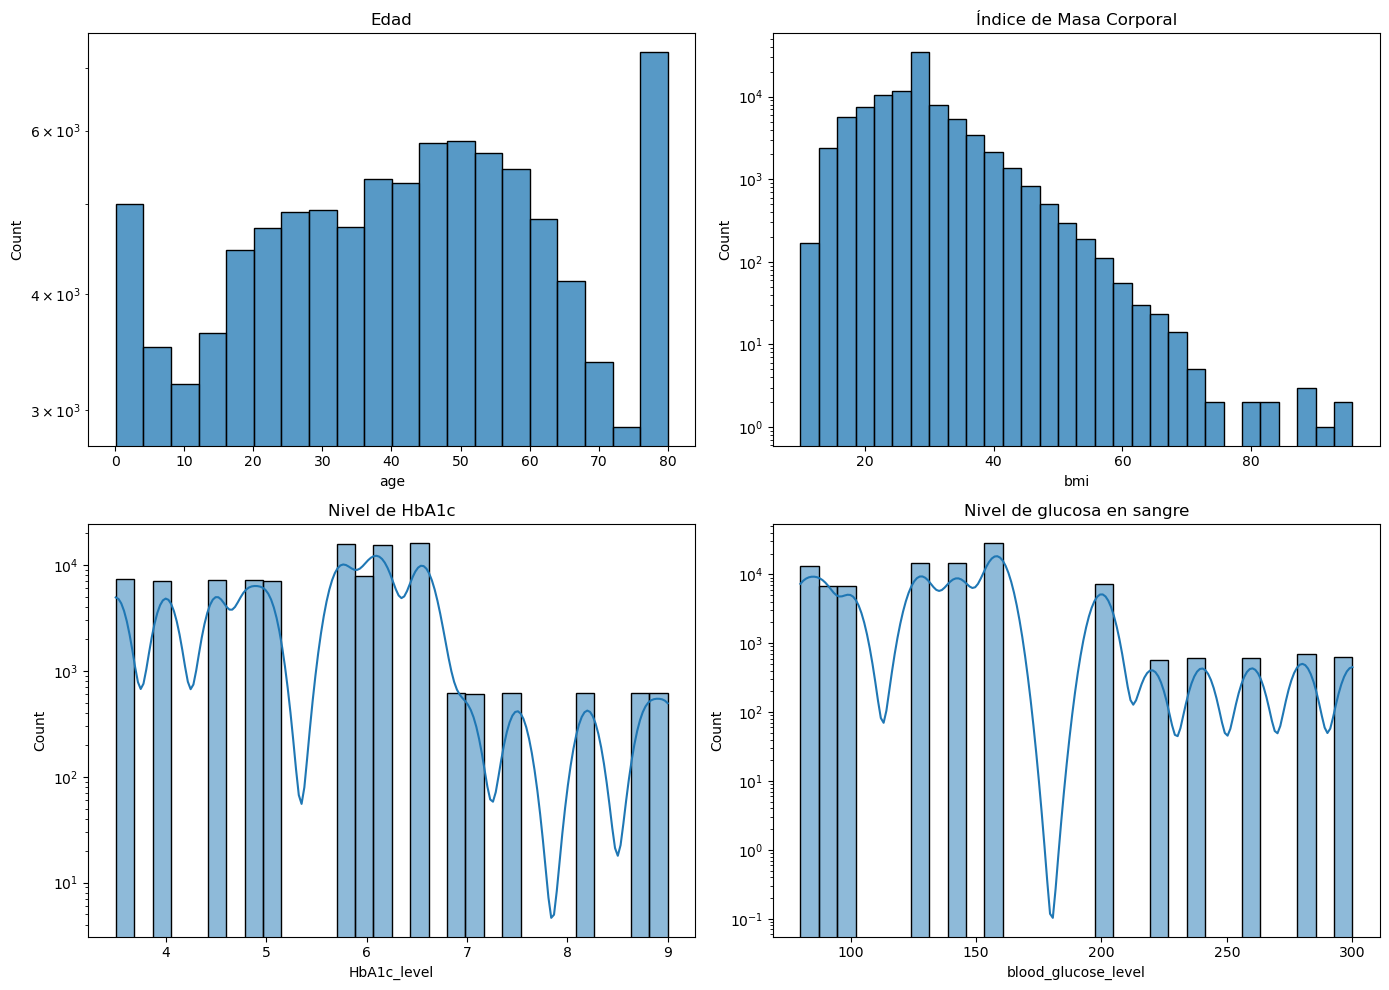

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))


sns.histplot(train_df['age'], ax=axes[0, 0], bins=20)
axes[0, 0].set_title('Edad')
axes[0, 0].set_yscale('log')

sns.histplot(train_df['bmi'], ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Índice de Masa Corporal')
axes[0, 1].set_yscale('log')

sns.histplot(train_df['HbA1c_level'], ax=axes[1, 0], bins=30, kde=True)
axes[1, 0].set_title('Nivel de HbA1c')
axes[1, 0].set_yscale('log')

sns.histplot(train_df['blood_glucose_level'], ax=axes[1, 1], bins=30, kde=True)
axes[1, 1].set_title('Nivel de glucosa en sangre')
axes[1, 1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

En cuanto a las variables numéricas, vemos que tenemos un gran número de pacientes de más de 85 años, y que existe un pico en la distribución de Índice de Masa Corporal (no tan notorio en la gráfica por el uso de escala logarítmica). Asimismo, vemos que los niveles de HbA1c y de glucosa en sangre se encuentran discretizados.

Antes de pasar al preprocesamiento, veamos cómo se relacionan estas variables con la variable objetivo.

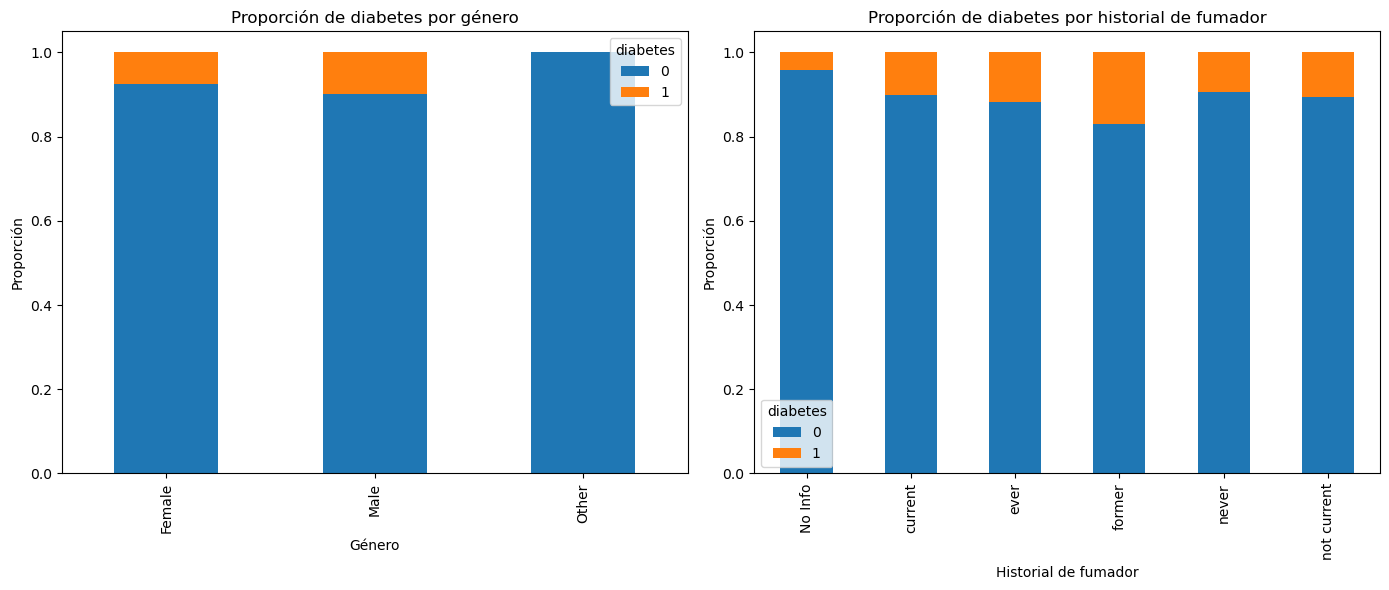

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 'gender'
grouped_gender = train_df.groupby('gender')['diabetes'].value_counts(normalize=True).unstack('diabetes')
grouped_gender.plot.bar(stacked=True, ax=axes[0])
axes[0].set_title('Proporción de diabetes por género')
axes[0].set_xlabel('Género')
axes[0].set_ylabel('Proporción')

# Plot for 'smoking_history'
grouped_smoking = train_df.groupby('smoking_history')['diabetes'].value_counts(normalize=True).unstack('diabetes')
grouped_smoking.plot.bar(stacked=True, ax=axes[1])
axes[1].set_title('Proporción de diabetes por historial de fumador')
axes[1].set_xlabel('Historial de fumador')
axes[1].set_ylabel('Proporción')

# Adjust layout
plt.tight_layout()
plt.show()

Vemos que en los hombres hay un porcentaje ligeramente mayor de diabetes, al igual que en quienes fumaron en algún momento de su vida (*former*).

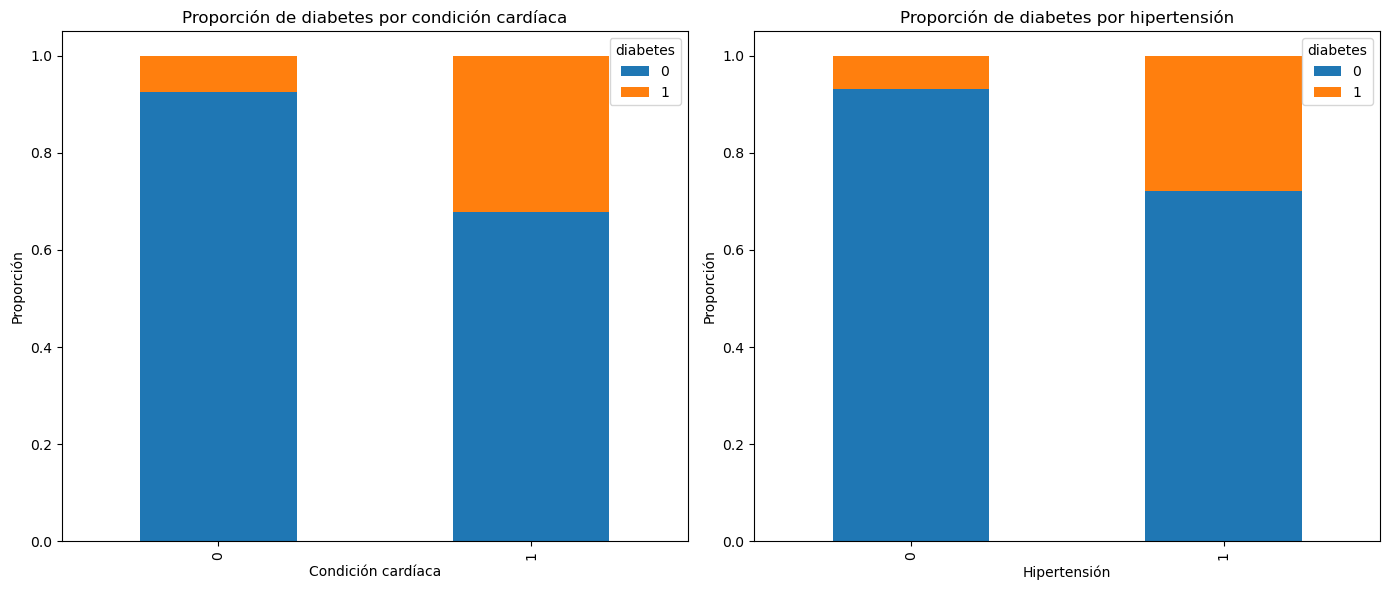

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 'gender'
grouped_gender = train_df.groupby('heart_disease')['diabetes'].value_counts(normalize=True).unstack('diabetes')
grouped_gender.plot.bar(stacked=True, ax=axes[0])
axes[0].set_title('Proporción de diabetes por condición cardíaca')
axes[0].set_xlabel('Condición cardíaca')
axes[0].set_ylabel('Proporción')

# Plot for 'smoking_history'
grouped_smoking = train_df.groupby('hypertension')['diabetes'].value_counts(normalize=True).unstack('diabetes')
grouped_smoking.plot.bar(stacked=True, ax=axes[1])
axes[1].set_title('Proporción de diabetes por hipertensión')
axes[1].set_xlabel('Hipertensión')
axes[1].set_ylabel('Proporción')

# Adjust layout
plt.tight_layout()
plt.show()

Como es de esperar, el porcentaje de pacientes con diabetes es mayor en aquellos que además tienen condiciones cardíacas o hipertensión.

In [ ]:

columns_to_plot= ['age', 'bmi', "HbA1c_level", "blood_glucose_level"]
sns.pairplot(train_df, hue="diabetes", corner=True, vars=columns_to_plot)

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Estas distribuciones nos permiten ver que la mayoría de los casos de diabetes se dan en edades mayores, bmis más altos, y niveles de HbA1c y glucosa más elevados. Si bien existe superposición en los histogramas, hay rangos donde sólo hay pacientes sin diabetes (por ejemplo HbA1c menor a 5.5) y rangos donde sólo hay pacientes con diabetes (HbA1c mayor a 7). 

También podemos chequear qué tan balanceadas o desbalanceadas están las clases.

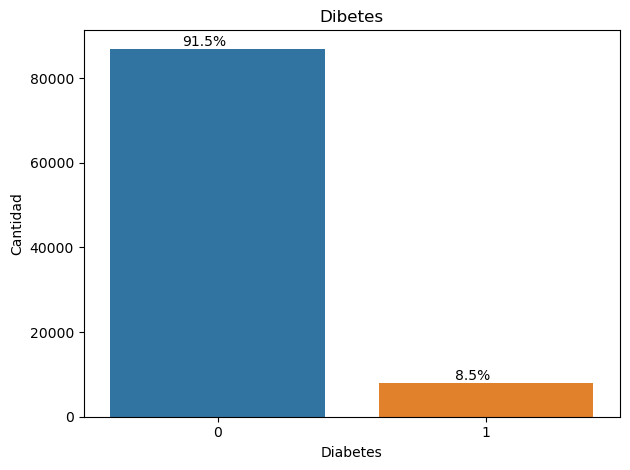

In [8]:
fig, ax = plt.subplots()
sns.countplot(ax=ax, x='diabetes', data=train_df)
ax.set_title('Dibetes')
ax.set_xlabel('Diabetes')
ax.set_ylabel('Cantidad')

total2 = len(train_df['diabetes'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total2)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Vemos que hay un desbalance marcado: por cada paciente con diabetes tenemos más de 10 pacientes sin diabetes. Esto es algo que será necesario tener en cuenta en nuestros modelos.

## 2. Preprocesamiento

Realizamos el siguiente preprocesamiento sobre el conjunto de datos:

- Encoding de las variables categóricas (Género e Historial de fumador)
- Separación en conjuntos de entrenamiento, validación y evaluación (70/20/10)
- Normalización

Al contar con algunas variables binarias, podemos anticipar que si quisieramos normalizar mediante ```StandardScaler``` obtendríamos lo siguiente (a partir de una distribución binomial):
$$\mu = \frac{n_1}{N},$$
donde $n_1$ es la cantidad de pacientes con hipertensión o condiciones cardíacas, y $N$ la cantidad total de pacientes, y:
$$\sigma = \frac{n_1\cdot n_0}{N}.$$

Para esta distribución de datos, el desvío estándar da en el orden de $7000$, lo cual hace que al normalizar tengamos dos valores posibles: 
$$1 \to \frac{1-0.085}{7000}\approx 1.3\times10^{-4}$$
$$0 \to \frac{0-0.085}{7000}\approx -1.2\times10^{-5}$$

Estos valores son demasiado pequeños, y probablemente estén en una escala muy distinta a la que obtendríamos al normalizar las variables continuas. Es por eso que consideramos más apropiado aplicar una normalización por ```MinMaxScaler```, transformando cada distribución al rango $[0,1]$.

Como ya es habitual en estos análisis, ajustamos el Scaler al conjunto de entrenamiento, y lo utilizamos para luego transformar los otros dos conjuntos.

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

y = train_df.diabetes
X = train_df.drop(['diabetes', 'patient'],axis=1)

num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
cat_cols = ['gender', 'smoking_history']
all_cols = num_cols + cat_cols + ['hypertension', 'heart_disease']

#Encoding de las variables categóricas
for col in cat_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, train_size=0.9, random_state = 7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=7/9, random_state = 7)

#StandardScaler para las variables numéricas
scaler = MinMaxScaler()
scaler.fit(x_train.values)

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print('Cantidad datos entrenamiento:',x_train_scaled.shape)
print('Cantidad datos validación:',x_val_scaled.shape)
print('Cantidad datos evaluación:',x_test_scaled.shape)

Cantidad datos entrenamiento: (66500, 8)
Cantidad datos validación: (19000, 8)
Cantidad datos evaluación: (9500, 8)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


## 3. Primer modelo: Red Neuronal Profunda

Uno de los modelos elegidos fue una Red Neuronal Profunda, utilizando ```Tensorflow```. Se fueron agregando (y a veces quitando) gradualmente herramientas adicionales para facilitar el entrenamiento, evitar el sobreajuste temprano y mejorar las métricas. El modelo final incorpora:

- *Class weights* para contrarrestar el desbalance de clases
- *Dropout* para evitar el sobreajuste
- *Early Stopping* una vez que la AUC (área bajo la curva ROC) deja de mejorar en el conjunto de validación. Se eligió esta métrica ya que no es sensible al desbalance de clases (a diferencia de la *accuracy*)
- Regularización L1 sobre las capas ocultas

Se probaron diferentes estructuras (números de capas y nodos por capa), funciones de activación y optimizadores, pero los mejores resultados se obtuvieron utilizando un modelo relativamente normal. Una ```GridSearch``` más exhaustiva podría encontrar un mejor modelo.

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1
from sklearn.utils.class_weight import compute_class_weight
import datetime

dropout_rate = 0.3
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'auc'])

early_stopping = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True)

history = model.fit(x_train_scaled, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_scaled, y_val),
                    class_weight = class_weights,
                    callbacks=[early_stopping])


Epoch 1/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.6011 - auc: 0.7484 - loss: 0.7125 - val_accuracy: 0.8865 - val_auc: 0.9563 - val_loss: 0.3756
Epoch 2/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8608 - auc: 0.9266 - loss: 0.4353 - val_accuracy: 0.9058 - val_auc: 0.9583 - val_loss: 0.2976
Epoch 3/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8597 - auc: 0.9370 - loss: 0.4001 - val_accuracy: 0.8743 - val_auc: 0.9601 - val_loss: 0.3407
Epoch 4/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8660 - auc: 0.9399 - loss: 0.3858 - val_accuracy: 0.8968 - val_auc: 0.9608 - val_loss: 0.2815
Epoch 5/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8592 - auc: 0.9387 - loss: 0.3866 - val_accuracy: 0.8979 - val_auc: 0.9605 - val_loss: 0.2747
Epoch 6/200
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8557 - auc: 0.9407 - loss: 0.3811 - val_accuracy: 0.9010 - val_auc: 0.9615 - val_loss: 0.2763
Epoch 7/200
207

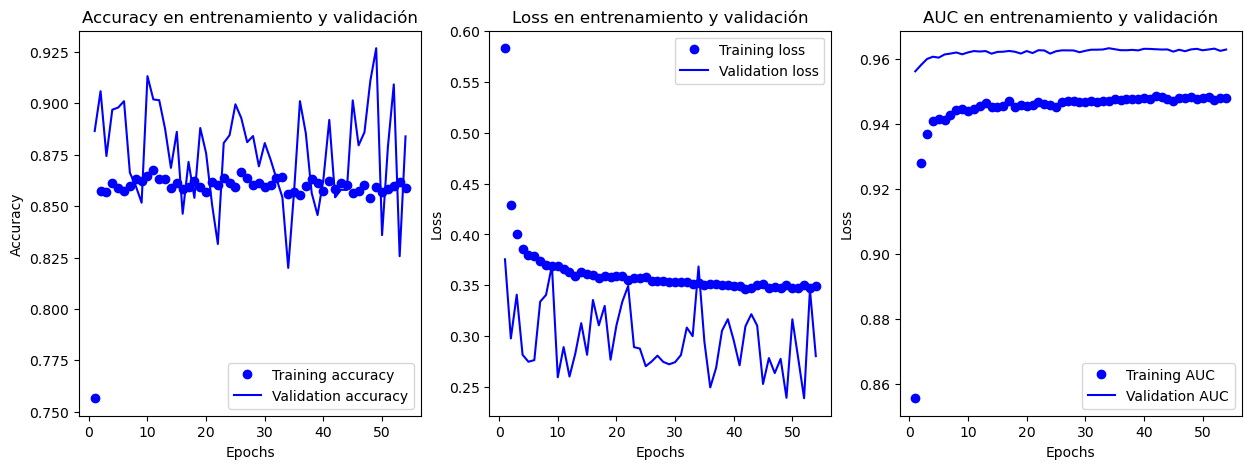

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Accuracy en entrenamiento y validación')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Loss en entrenamiento y validación')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(epochs, auc, 'bo', label='Training AUC')
ax[2].plot(epochs, val_auc, 'b', label='Validation AUC')
ax[2].set_title('AUC en entrenamiento y validación')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend()

plt.show()

Vemos que el entrenamiento es relativamente lento. Esto se debe en parte a la elección de un batch size pequeño, y a la falta de una normalización sobre cada batch (que fue implementada pero daba peores resultados). Si bien el optimizador ```ADAM``` ya actualiza el Learning Rate según el gradiente calculado, podría forzarse en un valor inicial más grande para agilizar el entrenamiento.

El clasificador entrenado nos da una variable continua entre 0 y 1, donde los valores más cercanos a 0 indican mayor probabilidad de no tener diabetes, y valores más cercanos a 1 probabilidades de sí tener. Vamos a determinar cuál es el umbral de corte que mejor separa las clases. Tengamos en cuenta que podemos elegir cualquier métrica a la hora de optimizar. Como el Leaderboard de Kaggle se realiza en base a la *accuracy*, apuntamos a optimizar esa métrica.

In [20]:
#Testing (interno)
predictions = model.predict(x_train_scaled)

thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_accuracy = 0

accuracies = []
for threshold in thresholds:
    binary_predictions = (predictions > threshold).astype(int).flatten()
    accuracy = accuracy_score(y_train, binary_predictions)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f'Mejor umbral: {best_threshold}')
print(f'Mejor accuracy: {best_accuracy}')

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Mejor umbral: 0.92
Mejor accuracy: 0.9600451127819549


Vamos a aplicar este modelo sobre el 10% de los datos de evaluación que reservamos anteriormente, para tener una idea de qué tan bueno será el desempeño sobre el dataset final:

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy de evaluación:0.9612631578947368


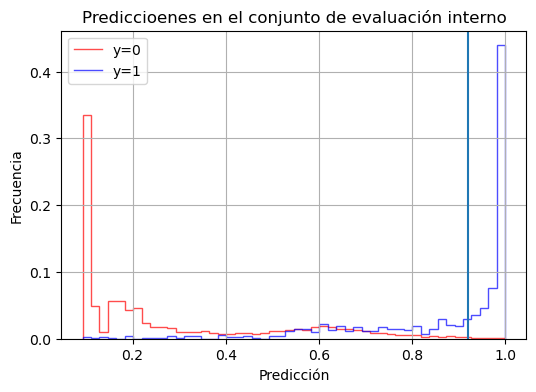

In [23]:
test_predictions = model.predict(x_test_scaled)
test_binary_predictions = (test_predictions > best_threshold).astype(int).flatten()
test_accuracy = accuracy_score(y_test, test_binary_predictions)
print(f'Accuracy de evaluación:{test_accuracy}')

x_test_0 = x_test_scaled[y_test == 0]
x_test_1 = x_test_scaled[y_test == 1]
predictions_0 = test_predictions[y_test == 0]
predictions_1 = test_predictions[y_test == 1]

counts_0, bin_edges = np.histogram(predictions_0, bins=50, density=True)
counts_1, bin_edges = np.histogram(predictions_1, bins=50, density=True)

d_0 = np.sum(counts_0)
d_1 = np.sum(counts_1)

fig, ax = plt.subplots(figsize=(6,4))

ax.stairs(counts_0/d_0, bin_edges, edgecolor='red', alpha=0.7, label='y=0')
ax.stairs(counts_1/d_1, bin_edges, edgecolor='blue', alpha=0.7, label='y=1')

ax.set_title('Prediccioenes en el conjunto de evaluación interno')
ax.set_xlabel('Predicción')
ax.set_ylabel('Frecuencia')
ax.axvline(best_threshold)
ax.legend()
ax.grid(True)

Finalmente, generamos las predicciones sobre el conjunto de evaluación de la competencia:

 20/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


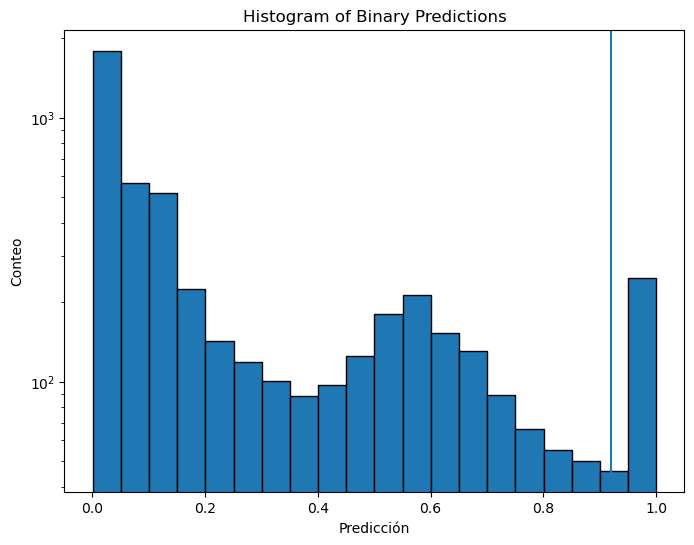

In [14]:
#Lectura
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
PatientId_test = test_df['patient']
X_sub = test_df.drop(['patient','diabetes'],axis=1)

#Preprocesamiento
for col in cat_cols:
    X_sub[col] = X_sub[col].astype(str)
    X_sub[col] = LabelEncoder().fit_transform(X_sub[col])

X_sub_scaled = scaler.transform(X_sub)
predictions = model.predict(X_sub_scaled)
threshold = best_threshold

#Gráfica de la predicción
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=20, edgecolor='black')
plt.xlabel('Predicción')
plt.ylabel('Conteo')
plt.yscale('log')
plt.axvline(threshold)
plt.title('Histogram of Binary Predictions')
plt.show()

# Convertimos las predicciones en una variable binaria con el umbral
binary_predictions = (predictions > threshold).astype(int).flatten()

# Creamos el archivo para subir a Kaggle
test_id = PatientId_test
test_pred = np.int64(binary_predictions)
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_dnn.csv", header=True, index=False)

## 4. Segundo modelo: Gradient Boosting con XGBoost

Vamos a realizar dos ```GridSeach``` sobre las posibles variables del modelo:

- Máxima profundidad de los árboles
- Learning Rate 
- Parámetro de Regularización L2
- Balance de pesos positivos y negativos
- Fracción de sampleo de columnas para construir cada árbol
- Fracción de sampleo para las instancias de entrenamiento

In [15]:
'''
import xgboost as xgb

grid1 = {'objective':['binary:logistic'],
  'max_depth': [7, 8, 10, 12],
  'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1],
  'reg_lambda':[0, 1, 2, 5],
  }

gridsearch_cv_object = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1),
                      param_grid = grid1,
                      scoring='roc_auc',
                      cv=5)

gridsearch_cv_object.fit(x_train, y_train)

best_params = gridsearch_cv_object.best_params_
best_params
'''

"\nimport xgboost as xgb\n\ngrid1 = {'objective':['binary:logistic'],\n  'max_depth': [7, 8, 10, 12],\n  'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1],\n  'reg_lambda':[0, 1, 2, 5],\n  }\n\ngridsearch_cv_object = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1),\n                      param_grid = grid1,\n                      scoring='roc_auc',\n                      cv=5)\n\ngridsearch_cv_object.fit(x_train, y_train)\n\nbest_params = gridsearch_cv_object.best_params_\nbest_params\n"

In [16]:
'''
grid2 = {'objective':['binary:logistic'],
  'scale_pos_weight': [10.75, 1],
  'colsample_bytree': [1, .5, .2],
  'subsample': [1, .75, .5, .2],
  }

gridsearch_cv_object2 = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1,
                                                                 learning_rate=0.1,
                                                                 max_depth=7,
                                                                 objective='binary:logistic',
                                                                 reg_lambda=2),
                      param_grid = grid2,
                      scoring='roc_auc',
                      cv=3)

gridsearch_cv_object2.fit(x_train, y_train)

best_params = gridsearch_cv_object2.best_params_
best_params
'''

"\ngrid2 = {'objective':['binary:logistic'],\n  'scale_pos_weight': [10.75, 1],\n  'colsample_bytree': [1, .5, .2],\n  'subsample': [1, .75, .5, .2],\n  }\n\ngridsearch_cv_object2 = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1,\n                                                                 learning_rate=0.1,\n                                                                 max_depth=7,\n                                                                 objective='binary:logistic',\n                                                                 reg_lambda=2),\n                      param_grid = grid2,\n                      scoring='roc_auc',\n                      cv=3)\n\ngridsearch_cv_object2.fit(x_train, y_train)\n\nbest_params = gridsearch_cv_object2.best_params_\nbest_params\n"

De todas formas, se encontró que la performance del modelo optimizado mediante la ```GridSearch``` no superó al modelo más sencillo "por defecto" de XGBoost. A continuación se muestra el entrenamiento del mismo. Vamos a realizar CrossValidation, sobre los datos de entrenamiento y validación, y finalmente evaluar sobre el 10% de datos restantes.

In [30]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, train_size=0.9, random_state = 7)

scaler = MinMaxScaler()
scaler.fit(x_train_val.values)

x_train_val_scaled = scaler.transform(x_train_val)
x_test = scaler.transform(x_test)

FOLDS=5

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

avg_accuracy = 0
avg_roc_auc = 0

clf = xgb.XGBClassifier()

for fold, (train_idx, val_idx) in enumerate(cv.split(x_train_val_scaled, y_train_val)):
    xi, yi = x_train_val_scaled[train_idx], np.array(y_train_val)[train_idx]
    x_valid, y_valid = x_train_val_scaled[val_idx], np.array(y_train_val)[val_idx]
    
    clf = clf.fit(xi, yi)

    test_predictions = clf.predict(x_valid)
    accuracy = accuracy_score(y_valid, test_predictions)
    rocauc = roc_auc_score(y_valid, test_predictions)
    avg_accuracy +=accuracy
    avg_roc_auc += rocauc
    print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())
    print(f"roc_auc test fold {fold}: {rocauc}" % ())

# Assign feature names to the booster
clf.get_booster().feature_names = feature_names

avg_accuracy /= FOLDS
avg_roc_auc /= FOLDS
print(f'Avg. accuracy = {avg_accuracy * 100}')
print(f'Avg. roc_auc score = {avg_roc_auc}')

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Precisión test fold 0: 97.13
roc_auc test fold 0: 0.8494623774374794
Precisión test fold 1: 97.03
roc_auc test fold 1: 0.8439131871763799
Precisión test fold 2: 96.97
roc_auc test fold 2: 0.8360846094524623
Precisión test fold 3: 96.99
roc_auc test fold 3: 0.8387154346149609
Precisión test fold 4: 97.32
roc_auc test fold 4: 0.8549640570828899
Avg. accuracy = 97.08771929824562
Avg. roc_auc score = 0.8446279331528345


Visualizando el modelo:

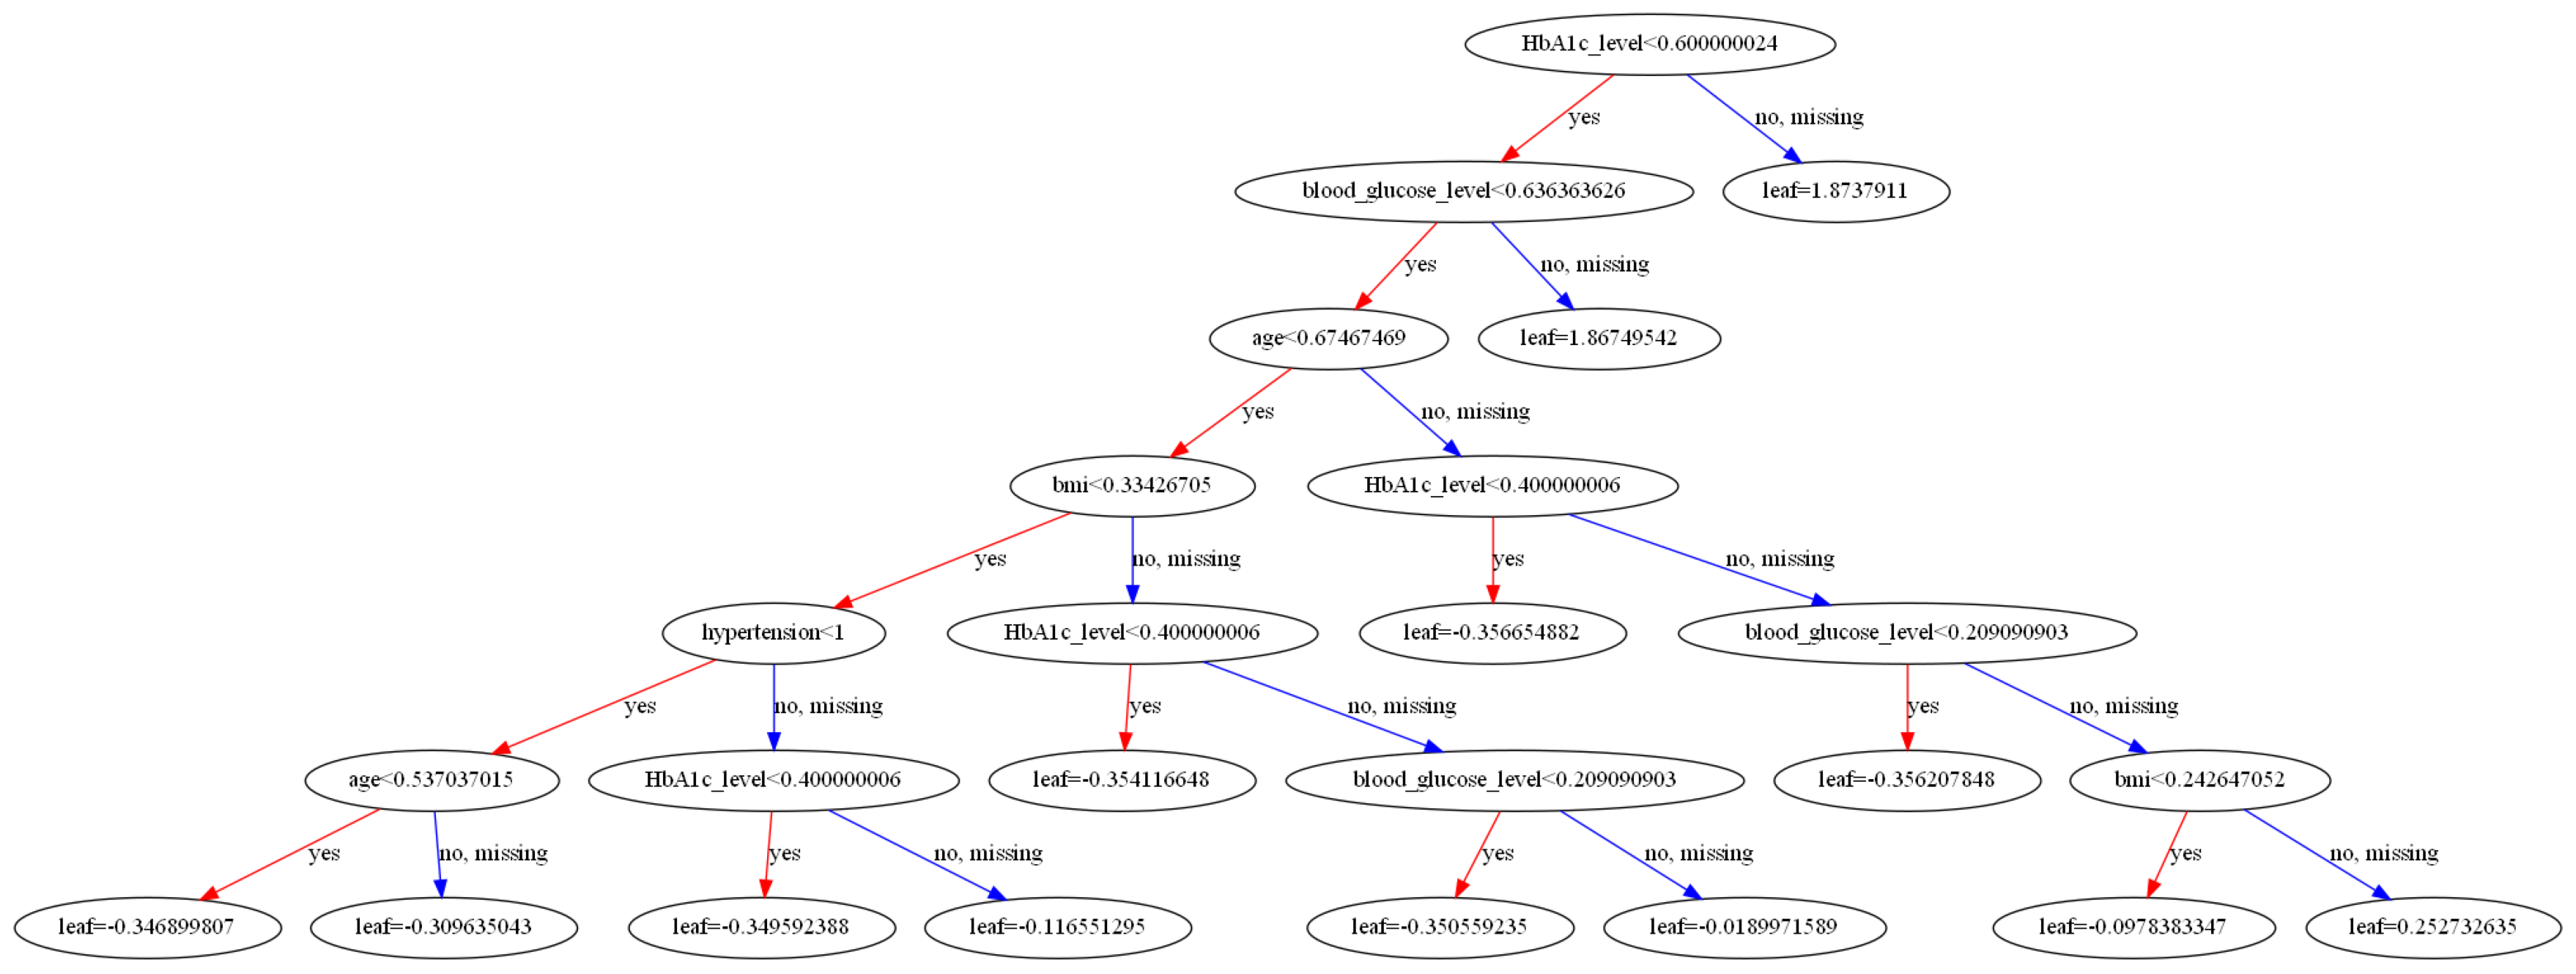

In [36]:
fig, ax = plt.subplots(figsize=(40, 20))
  # Increase figure size
xgb.plot_tree(clf, num_trees=0, ax=ax)
plt.show()
plt.close()

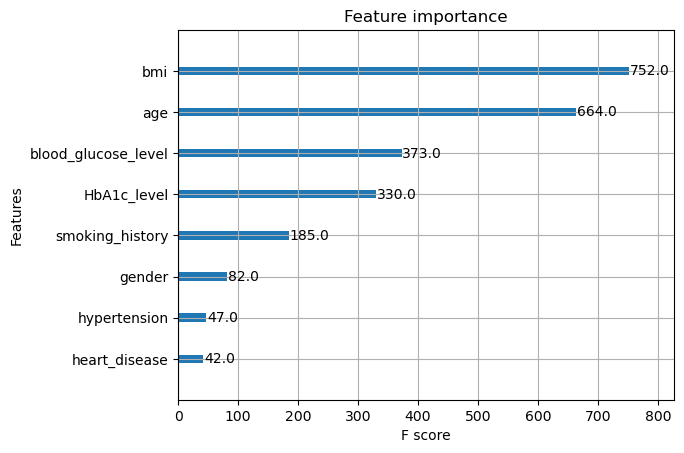

In [32]:
xgb.plot_importance(clf)
plt.show()

Accuracy de evaluación:0.972


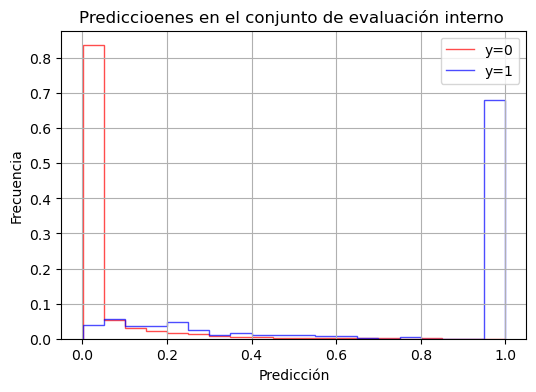

In [49]:
test_predictions = clf.predict_proba(x_test_scaled)[:,1]
test_binary_predictions = (test_predictions > best_threshold).astype(int).flatten()
test_accuracy = accuracy_score(y_test, test_binary_predictions)
print(f'Accuracy de evaluación:{test_accuracy}')

x_test_0 = x_test_scaled[y_test == 0]
x_test_1 = x_test_scaled[y_test == 1]
predictions_0 = test_predictions[y_test == 0]
predictions_1 = test_predictions[y_test == 1]

counts_0, bin_edges = np.histogram(predictions_0, bins=20, density=True)
counts_1, bin_edges = np.histogram(predictions_1, bins=20, density=True)

d_0 = np.sum(counts_0)
d_1 = np.sum(counts_1)

fig, ax = plt.subplots(figsize=(6,4))

ax.stairs(counts_0/d_0, bin_edges, edgecolor='red', alpha=0.7, label='y=0')
ax.stairs(counts_1/d_1, bin_edges, edgecolor='blue', alpha=0.7, label='y=1')

ax.set_title('Prediccioenes en el conjunto de evaluación interno ')
ax.set_xlabel('Predicción')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True)

Hacemos las predicciones en el conjunto para subir a Kaggle

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


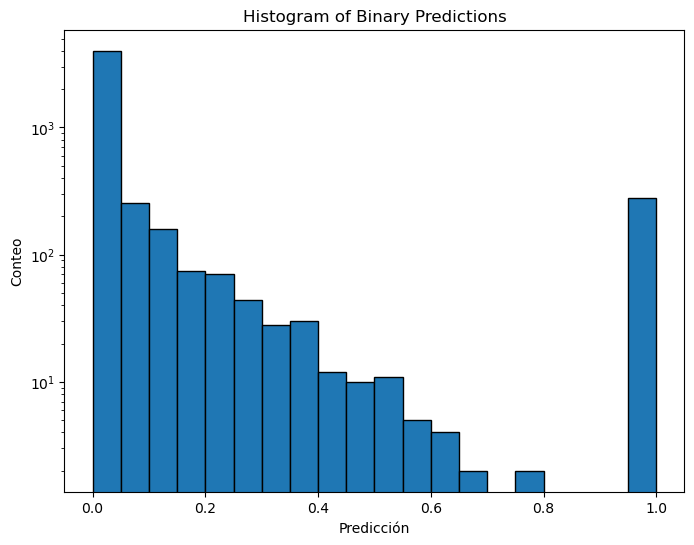

In [51]:
#Lectura
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
PatientId_test = test_df['patient']
X_sub = test_df.drop(['patient','diabetes'],axis=1)

#Preprocesamiento
for col in cat_cols:
    X_sub[col] = X_sub[col].astype(str)
    X_sub[col] = LabelEncoder().fit_transform(X_sub[col])

X_sub_scaled = scaler.transform(X_sub)
predictions = clf.predict_proba(X_sub_scaled)

plt.figure(figsize=(8, 6))
plt.hist(predictions[:,1], bins=20, edgecolor='black')
plt.xlabel('Predicción')
plt.ylabel('Conteo')
plt.yscale('log')
plt.title('Histogram of Binary Predictions')
plt.show()

# Creamos el archivo para subir a Kaggle
test_id = PatientId_test
test_pred = predictions[:,0]
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_clf.csv", header=True, index=False)

## 5. Tercer modelo: Gradient Boosting con LightGBM

In [53]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

# Crear el pipeline con el modelo LightGBM
pipeline = Pipeline(steps=[
    ('lgbm', lgb.LGBMClassifier(random_state=42))
])

# Definir el rango de hiperparámetros para el modelo
param_dist = {
    'lgbm__num_leaves': [31, 50, 100],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__n_estimators': [100, 200, 300],
    'lgbm__max_depth': [10, 20, 30],
    'lgbm__min_child_samples': [20, 50, 100],
    'lgbm__subsample': [0.6, 0.8, 1.0],
    'lgbm__colsample_bytree': [0.6, 0.8, 1.0],
}

# Configurar RandomizedSearchCV
lgbm_random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo
lgbm_random_search.fit(x_train_scaled, y_train)

# Mejor modelo
best_lgbm_model = lgbm_random_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred_best_lgbm = best_lgbm_model.predict(x_val_scaled)
y_prob_best_lgbm = best_lgbm_model.predict_proba(x_val_scaled)[:, 1]

print("LightGBM con RandomizedSearchCV")
print("Mejores parámetros:", lgbm_random_search.best_params_)
print("Accuracy en el conjunto de validación:", accuracy_score(y_val, y_pred_best_lgbm))
print(classification_report(y_val, y_pred_best_lgbm))
print("ROC AUC Score en el conjunto de validación:", roc_auc_score(y_val, y_prob_best_lgbm))

# Predicciones en el conjunto de prueba
y_test_pred = best_lgbm_model.predict(X_sub_scaled)

# Crear un DataFrame con las columnas 'patient' y 'diabetes'
result_df = test_df[['patient']].copy()
result_df['diabetes'] = y_test_pred

# Guardar las predicciones en un archivo CSV
result_df.to_csv('predicciones_lgbm.csv', index=False)

[LightGBM] [Info] Number of positive: 5670, number of negative: 60830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 66500, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085263 -> initscore=-2.372894
[LightGBM] [Info] Start training from score -2.372894
LightGBM con RandomizedSearchCV
Mejores parámetros: {'lgbm__subsample': 1.0, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 300, 'lgbm__min_child_samples': 50, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.01, 'lgbm__colsample_bytree': 0.8}
Accuracy en el conjunto de validación: 0.9743157894736842
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17419
           1       0.99      0.70   

También podemos grafican los valores de salida:

Accuracy de evaluación:0.9485263157894737


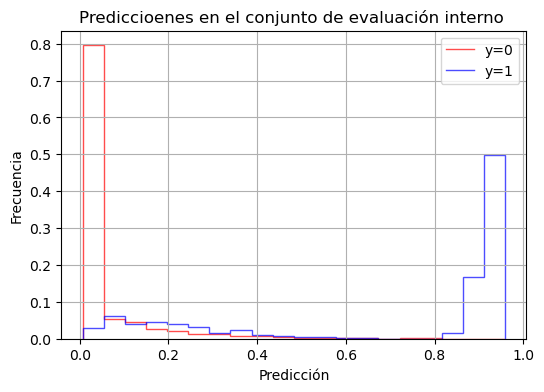

In [55]:
test_predictions = best_lgbm_model.predict_proba(x_test_scaled)[:,1]
test_binary_predictions = (test_predictions > best_threshold).astype(int).flatten()
test_accuracy = accuracy_score(y_test, test_binary_predictions)
print(f'Accuracy de evaluación:{test_accuracy}')

x_test_0 = x_test_scaled[y_test == 0]
x_test_1 = x_test_scaled[y_test == 1]
predictions_0 = test_predictions[y_test == 0]
predictions_1 = test_predictions[y_test == 1]

counts_0, bin_edges = np.histogram(predictions_0, bins=20, density=True)
counts_1, bin_edges = np.histogram(predictions_1, bins=20, density=True)

d_0 = np.sum(counts_0)
d_1 = np.sum(counts_1)

fig, ax = plt.subplots(figsize=(6,4))

ax.stairs(counts_0/d_0, bin_edges, edgecolor='red', alpha=0.7, label='y=0')
ax.stairs(counts_1/d_1, bin_edges, edgecolor='blue', alpha=0.7, label='y=1')

ax.set_title('Prediccioenes en el conjunto de evaluación interno ')
ax.set_xlabel('Predicción')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True)

## Final

Por último, vamos a comparar los modelos graficando las curvas ROC sobre el conjunto de evaluación interno:


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(9500, 1)


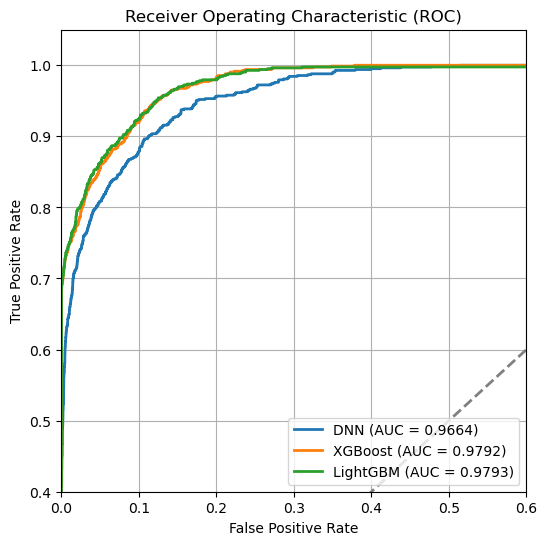

In [66]:
from sklearn.metrics import roc_curve, auc

#DNN
y_pred_dnn = model.predict(x_test_scaled)
print(y_pred_dnn.shape)
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

#XGBoost
y_pred_clf = clf.predict_proba(x_test_scaled)[:,1]
fpr_clf, tpr_clf, _ = roc_curve(y_test, y_pred_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)

#LightGBM
y_pred_lgbm = best_lgbm_model.predict_proba(x_test_scaled)[:,1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Plot ROC curves for each class
plt.figure(figsize=(6, 6))
colors = ['blue', 'red', 'green']  # Adjust colors if needed

plt.plot(fpr_dnn, tpr_dnn, lw=2, label=f'DNN (AUC = {roc_auc_dnn:.4f})')
plt.plot(fpr_clf, tpr_clf, lw=2, label=f'XGBoost (AUC = {roc_auc_clf:.4f})')
plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
plt.xlim([0.0, 0.6])
plt.ylim([0.4, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Vemos que la performance de los 3 modelos es similar, siendo casi igual entre XGBoost y LightGBM, y levemente inferior en la DNN.